In [126]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

# from tensorflow.keras import models,layers,preprocessing as kprocessing
# from tensorflow.keras import backend as K

# import transformers

import numpy as np

In [127]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [128]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [129]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [130]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. 
**** NEED to remove that in AWS

In [131]:
df = get_samples(df,100000)

In [132]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [133]:
df.shape

(100000, 4)

In [134]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer

In [135]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A
1035008,6,Who is the Sunday Night Football opening monta...,Sunday Night Football on NBC has a new opening...,Pat Benatar..she is still hottt!!!,Who is the Sunday Night Football opening monta...,Who is the Sunday Night Football opening monta...
1349063,6,What kind of strings or string combinations sh...,I use a HEAD flexpoint radical and hit alot of...,You should try Luxilon Big Banger Alu Power (w...,What kind of strings or string combinations sh...,What kind of strings or string combinations sh...
507330,1,"Well, to put it plain for all the ""bone-heads""...","Do you have illegal Mexicans working in ""YOUR""...",Illegal immigration is wrong in every since. ...,"Well, to put it plain for all the ""bone-heads""...","Well, to put it plain for all the ""bone-heads""..."
592400,10,the top three priorities the Untied States sho...,what are the top three priorities the Untied S...,Security of USA\n - avoidance of war\nSecurity...,the top three priorities the Untied States sho...,the top three priorities the Untied States sho...
502814,4,Where can I get an academic essay for free?,I don't want to plagerise or anything I'm just...,Academic knowledge is the basis on which futur...,Where can I get an academic essay for free?I d...,Where can I get an academic essay for free?I d...


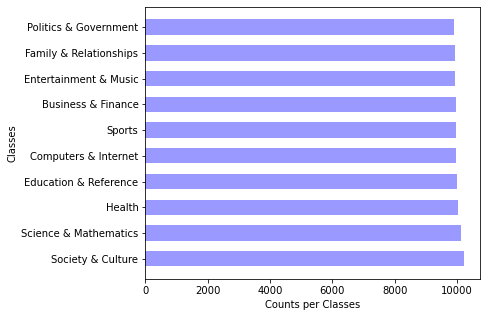

In [136]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [137]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [138]:
lst_stopwords = stopwords.words('english')

In [139]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", str(text).lower().strip())
    text = re.sub(' 0 ',' ',str(text).lower().strip())
    text = re.sub(' 00 ',' ',str(text).lower().strip())
    text = re.sub(' 000 ',' ',str(text).lower().strip())
    
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [140]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [141]:
df.head(10)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new
1035008,6,Who is the Sunday Night Football opening monta...,Sunday Night Football on NBC has a new opening...,Pat Benatar..she is still hottt!!!,Who is the Sunday Night Football opening monta...,Who is the Sunday Night Football opening monta...,sunday night footbal open montag vocalist sund...
1349063,6,What kind of strings or string combinations sh...,I use a HEAD flexpoint radical and hit alot of...,You should try Luxilon Big Banger Alu Power (w...,What kind of strings or string combinations sh...,What kind of strings or string combinations sh...,kind string string combin get tenni racket use...
507330,1,"Well, to put it plain for all the ""bone-heads""...","Do you have illegal Mexicans working in ""YOUR""...",Illegal immigration is wrong in every since. ...,"Well, to put it plain for all the ""bone-heads""...","Well, to put it plain for all the ""bone-heads""...",well put plain bone head view illeg immigr ill...
592400,10,the top three priorities the Untied States sho...,what are the top three priorities the Untied S...,Security of USA\n - avoidance of war\nSecurity...,the top three priorities the Untied States sho...,the top three priorities the Untied States sho...,top three prioriti unti state consid develop f...
502814,4,Where can I get an academic essay for free?,I don't want to plagerise or anything I'm just...,Academic knowledge is the basis on which futur...,Where can I get an academic essay for free?I d...,Where can I get an academic essay for free?I d...,get academ essay free want plageris anyth look...
88284,7,how does one register a patent in Canada?,,Complete a patent application at - https://str...,how does one register a patent in Canada?,how does one register a patent in Canada?Compl...,one regist patent canada complet patent applic...
955384,3,How many cups of coffee have you taken in your...,,lets see-- 3 cups a day times 7 days for 28 y...,How many cups of coffee have you taken in your...,How many cups of coffee have you taken in your...,mani cup coffe taken entir life estim thank le...
410627,7,where can I get a home/debt consolidation loan...,I would like to have a chance to start over wi...,Go to Lendingtree.com\n\nI got a Mortgage afte...,where can I get a home/debt consolidation loan...,where can I get a home/debt consolidation loan...,get home debt consolid loan bad credit would l...
495903,10,Who would make the best candidate for a republ...,,John McCain,Who would make the best candidate for a republ...,Who would make the best candidate for a republ...,would make best candid republican presidenti c...
622967,6,Will the Eagles reclaim the NFC....and maybe p...,,"Hell yeah, The eagles are going back on top. W...",Will the Eagles reclaim the NFC....and maybe p...,Will the Eagles reclaim the NFC....and maybe p...,eagl reclaim nfc mayb possibl go superbowl hel...


In [142]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [143]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
1035008,6,Who is the Sunday Night Football opening monta...,Sunday Night Football on NBC has a new opening...,Pat Benatar..she is still hottt!!!,Who is the Sunday Night Football opening monta...,Who is the Sunday Night Football opening monta...,sunday night footbal open montag vocalist sund...,54,254,5,4.703704,10.8
1349063,6,What kind of strings or string combinations sh...,I use a HEAD flexpoint radical and hit alot of...,You should try Luxilon Big Banger Alu Power (w...,What kind of strings or string combinations sh...,What kind of strings or string combinations sh...,kind string string combin get tenni racket use...,160,690,8,4.312500,20.0


In [144]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

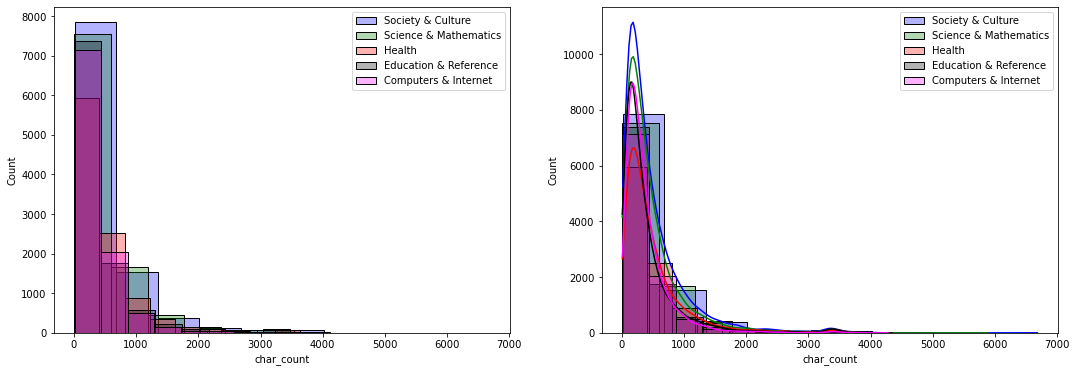

In [145]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [146]:
df.groupby('target').word_count.median()

target
1     70
2     65
3     75
4     51
5     59
6     45
7     53
8     41
9     73
10    72
Name: word_count, dtype: int64

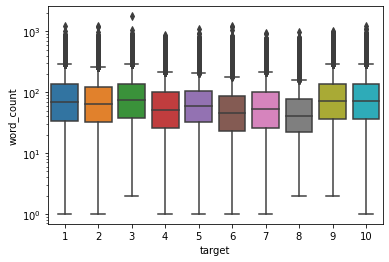

In [147]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

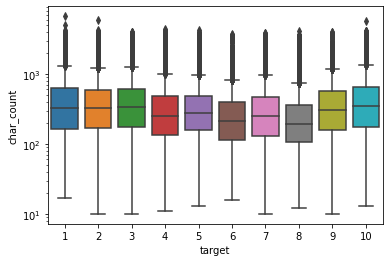

In [148]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

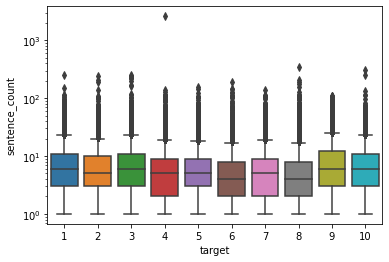

In [149]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

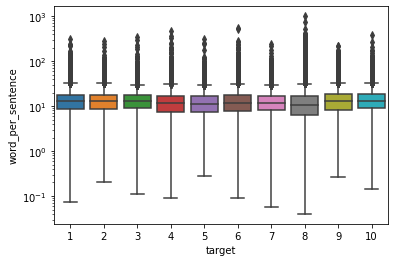

In [150]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [151]:
X = df.Text_new
y = df.target

In [152]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [153]:
vect = TfidfVectorizer(max_features=5000,ngram_range=(1,2))

In [154]:
XX_train = vect.fit_transform(X_train)

In [155]:
XX_test = vect.fit_transform(X_test)

In [156]:
vocab = vect.vocabulary_

In [157]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [158]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    df_features = df_features.sort_values(["y","Score"],ascending=[True,False])
    df_features = df_features[df_features.Score>0.95]

X_names_unique = df_features.feature.unique().tolist()
len(X_names_unique)

4356

In [159]:
df_features.head(5)

,feature,Score,y
149,almost everi,1.0,1
315,atmospher,1.0,1
423,belong,1.0,1
424,belt,1.0,1
425,ben,1.0,1


In [160]:
for category in np.unique(y_train):
    print(f'category {category}:',target_classes[category-1])
    print(f'length of category {category}:',len(df_features[df_features.y==category]))
    print(",".join(df_features[df_features.y==category].feature[:30]))
    print("")

category 1: Society & Culture
length of category 1: 990
almost everi,atmospher,belong,belt,ben,big,big deal,bigger,blood vessel,catalog,catalyst,cholesterol,choos,chose,christian,coverag,crime,equival,essay,ever sinc,exact,extrem,follow rule,gallon,get use,gi,go happen,go home,go www,goat

category 2: Science & Mathematics
length of category 2: 1538
2b,2nd,3x,4x,5th,ac,accid,act like,alaska,alli,angl,attempt,attend,backward,band,bill,bit,bleed,border,california,carbohydr,carbon,cd,cheek,cheer,chosen,christma,clip,close,cloth

category 3: Health
length of category 3: 1477
abil,absenc,across,activ,almost year,alon,any1,anybodi know,artist,band,benefici,bite,black hole,block,blood pressur,bob,boil,bomb,boot,borrow,brave,breast,britain,british,burn fat,butt,came,candi,car,card

category 4: Education & Reference
length of category 4: 750
accept,achiev,adventur,boston,citat,citizen,coach,deep,devic,differ peopl,earthquak,easi,emot,entitl,everi time,field,graduat,grammar,grant,graphic,highest

In [161]:
vect = TfidfVectorizer(vocabulary=X_names_unique)

In [162]:
XX_train = vect.fit_transform(X_train)
XX_train.shape

(90000, 4356)

In [163]:
XX_test = vect.transform(X_test)

In [164]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [165]:
# Creating a cloud of words

In [166]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

In [167]:
Text = " ".join(df_features[df_features.y==6].feature[:30])
Text

'argu art atom avatar bare batteri bc be bee bin laden brazil brief capit caviti ce cfm chain check check site chemic reaction clock cloud commerc could help crash crimin current custom dark decreas'

In [168]:
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

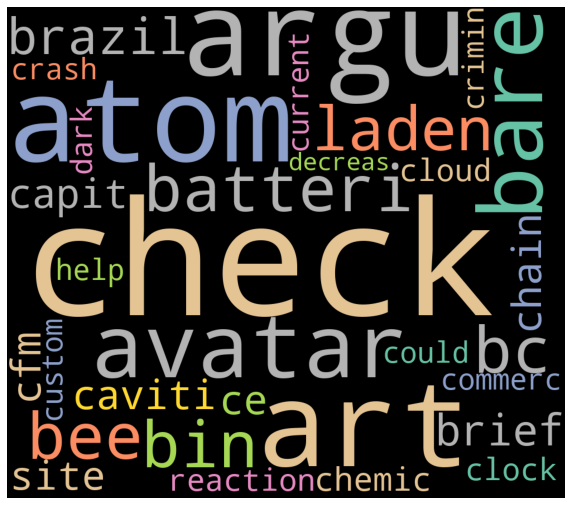

In [169]:
plot_cloud(wordcloud)

In [170]:
cvec = CountVectorizer(max_features=5000, ngram_range=(1, 2),stop_words='english')

In [171]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec  = cvec.transform(X_test)

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [173]:
nb = naive_bayes.MultinomialNB()

In [174]:
# # pipeline
# model = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",nb)])

In [178]:
cross_val_score(nb,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6520888888888889

In [179]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
nb.fit(XX_train,y_train)

MultinomialNB()

In [181]:
## Test Classifier
Predicted = nb.predict(XX_test)
Predicted_prob = nb.predict_proba(XX_test)

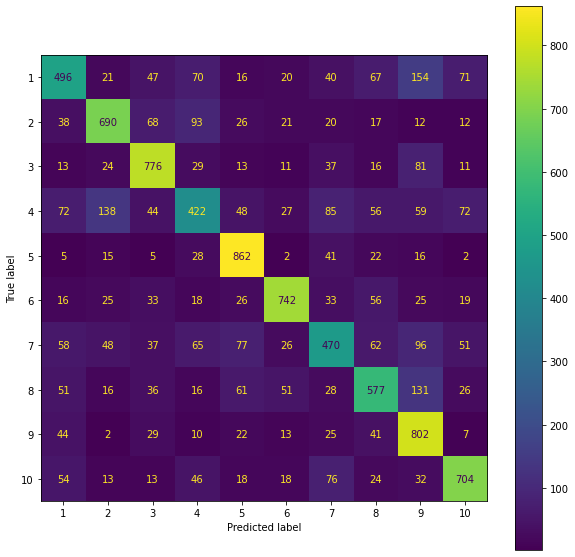

In [183]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(nb,XX_test,y_test,ax=ax);

In [184]:
cross_val_score(nb,X_train_cvec,y_train,cv=5,n_jobs=-1).mean()

0.6568444444444445

### Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [185]:
model_lr = LogisticRegression(max_iter=5000)

In [186]:
# # pipeline
# model_lr = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",lr)])

In [187]:
cross_val_score(model_lr,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6601222222222222

In [188]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(XX_train,y_train)

LogisticRegression(max_iter=5000)

In [189]:
## Test Classifier
Predicted = model_lr.predict(XX_test)
Predicted_prob = model_lr.predict_proba(XX_test)

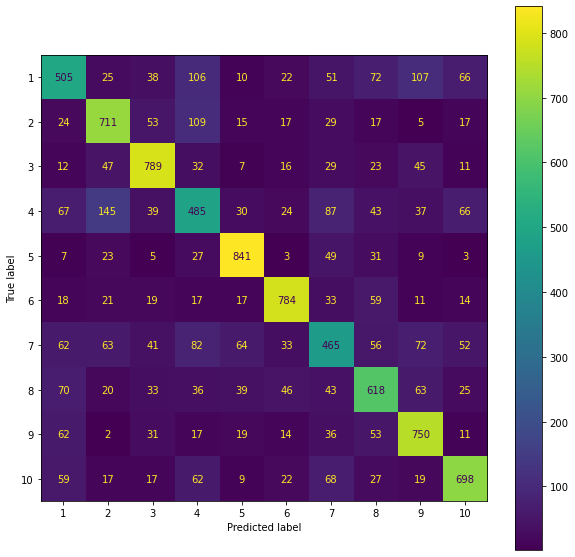

In [190]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,XX_test,y_test,ax=ax);

### Random Forest Classifier
In this section, we will use random forest classiier to fit our model to the training dataset

In [191]:
model_rf = RandomForestClassifier(n_estimators=1000,n_jobs=-1)

In [125]:
# # pipeline
# model_rf = pipeline.Pipeline([("vectorizer",vect),
#                               ("classifier",rf)])

(90000,)

In [192]:
cross_val_score(model_rf,XX_train,y_train,cv=5,n_jobs=-1)

array([0.60172222, 0.60683333, 0.60166667, 0.59877778, 0.60116667])

In [193]:
model_rf.fit(XX_train,y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [194]:
## Test Classifier
Predicted_rf = model_rf.predict(XX_test)
Predicted_prob_rf = model_rf.predict_proba(XX_test)

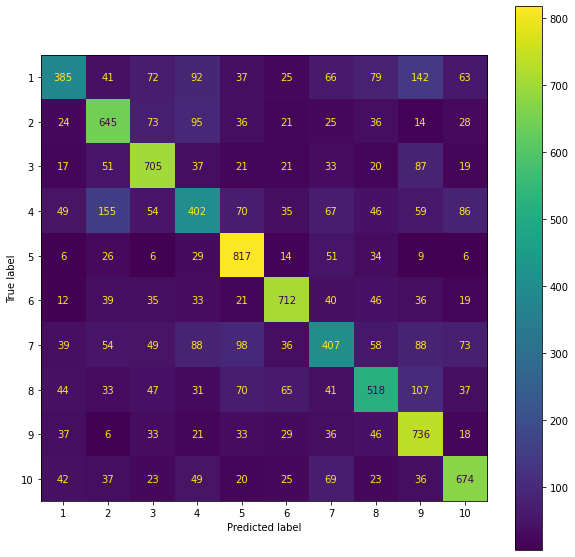

In [195]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_rf,XX_test,y_test,ax=ax);

In [196]:
classes = np.unique(y_test)
y_test_dummy = pd.get_dummies(y_test).values

accuracy = accuracy_score(y_test,Predicted)
auc = roc_auc_score(y_test,Predicted_prob,multi_class='ovr')

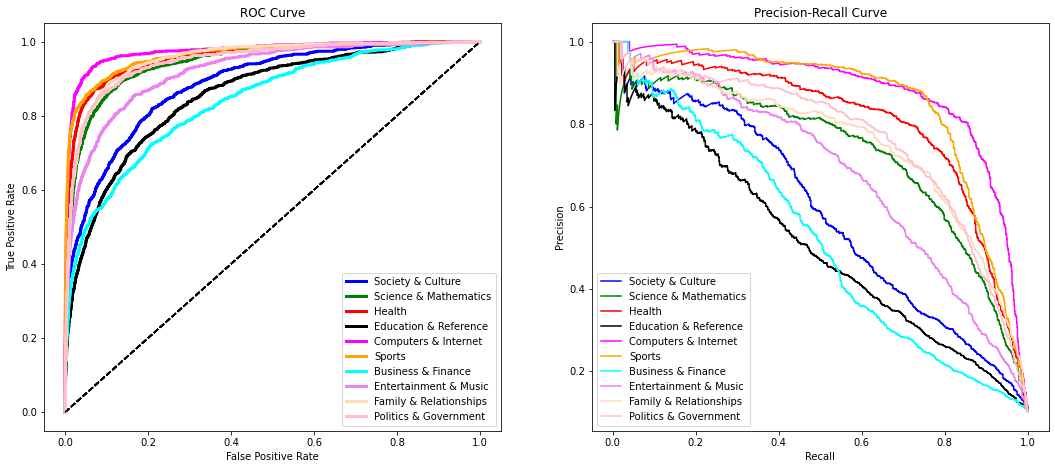

In [197]:
fig,axs = plt.subplots(1,2,figsize=(18,7.5))
for i in range(10):
    # ROC Curve
    fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[0].plot(fpr,tpr,lw=3,label=target_classes[i],color=colors[i])
    axs[0].plot([0,1],[0,1],color='k',ls='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()
    axs[0].set_title('ROC Curve')
    # Precision-Recall Curve
    precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[1].plot(recall,precision,label=target_classes[i],color=colors[i])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend()
    

In [ ]:
# Testing the error
# X_test[y_test!=Predicted].iloc[1]
# y_test[y_test!=Predicted]
# Predicted[y_test!=Predicted]


### USE THE BELOW LINES FOR DEBUGGING

In [201]:
test_set = 21
text = X_test.iloc[test_set]
text

'object data handl system help handl usual larg data system consist high input data requir high output data ie search engin'

In [202]:
print('Actual class -->',y_test.iloc[test_set],'|     Predicted class is -->',Predicted[test_set],
      '|     Probability -->  ',np.max(Predicted_prob[test_set]))
print('Actual class -->',target_classes[y_test.iloc[test_set]-1])
print('Predicted class -->',target_classes[Predicted[test_set]-1])

Actual class --> 7 |     Predicted class is --> 5 |     Probability -->   0.4128247826917109
Actual class --> Business & Finance
Predicted class --> Computers & Internet


In [203]:
# explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explainer = lime_text.LimeTextExplainer(class_names=target_classes)

In [204]:
explained = explainer.explain_instance(text,model.predict_proba,num_features=3,top_labels=1)

In [205]:
explained.show_in_notebook(text=text,predict_proba=True)

In [71]:
g = df[df.target==7]
g.head()

,target,question_title,question_content,best_answer,Q,Q&A,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
142643,7,Do you think fat girls should get all dressed ...,,why not? are you suggesting that you would fee...,Do you think fat girls should get all dressed ...,Do you think fat girls should get all dressed ...,think fat girl get dressed go prom suggesting ...,80,306,5,3.825000,16.000000
482855,7,How do I find companies needing machining work...,I have a machine shop in my garage but am havi...,door to door sales,How do I find companies needing machining work...,How do I find companies needing machining work...,find company needing machining work done machi...,27,128,2,4.740741,13.500000
814384,7,cv- need help?,"what do i include in a CV? sorry, never writte...","Ok, firstly you need to decide on whether you ...",cv- need help?what do i include in a CV? sorry...,cv- need help?what do i include in a CV? sorry...,cv need help include cv sorry never written on...,256,1112,28,4.343750,9.142857
844762,7,small bisnis for me? some ideas ?,,This is a very good business. Please click on ...,small bisnis for me? some ideas ?,small bisnis for me? some ideas ?This is a ver...,small bisnis idea good business please click h...,83,398,8,4.795181,10.375000
1249765,7,has anyone consolidated before? if so did it w...,,You need to be more specific. Do you mean cons...,has anyone consolidated before? if so did it w...,has anyone consolidated before? if so did it w...,anyone consolidated work need specific mean co...,53,256,3,4.830189,17.666667


In [87]:
# sum_=0
# lst=[]
# lst2=[]
# for i,text in enumerate(g.Text_new):
#     if 'acid' in text:
#         sum_ +=1
#         lst.append(text)
#         lst2.append(i)